<center><h2><b>Imports</b></h2></center>

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# KKMA

In [32]:
from konlpy.tag import Kkma
kkma = Kkma()

In [33]:
#영화리뷰 데이터 읽어오기
df = pd.read_csv("./data/processed/base_df.csv", encoding='utf-8')

#불용어 읽어오기
stopwords = pd.read_csv("./data/stopwords.txt")
stopwords = stopwords['word'].tolist()

<center><h2><b>Data Preprocessing</b></h2></center>

In [34]:
# Tokenized 
tk = []
for sentence in tqdm(df['review']) :
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tk.append(stopwords_removed_sentence)

100%|██████████| 9304/9304 [03:37<00:00, 42.85it/s] 


In [35]:
tk[:3]

[['판타지',
  '넘',
  '영화',
  '역사',
  '남',
  '명작',
  '다',
  '내',
  '극장',
  '못',
  '보',
  '았',
  '을까',
  '폰',
  '보',
  '았',
  '감동',
  '비',
  '교가',
  '안',
  '되',
  'ㄹ',
  '터',
  'ㄴ데'],
 ['이집트', '여행', '느낌', '영화'],
 ['목포', '연설', '장면', '넋', '잃', '고', '보', '게', '되', 'ㄴ다']]

In [36]:
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tk)

In [37]:
print(tokenizer.word_counts)
print(tokenizer.word_index)

OrderedDict([('판타지', 40), ('넘', 150), ('영화', 4310), ('역사', 37), ('남', 287), ('명작', 144), ('다', 3712), ('내', 304), ('극장', 91), ('못', 175), ('보', 4205), ('았', 2508), ('을까', 114), ('폰', 4), ('감동', 342), ('비', 103), ('교가', 1), ('안', 624), ('되', 1254), ('ㄹ', 2776), ('터', 86), ('ㄴ데', 384), ('이집트', 4), ('여행', 17), ('느낌', 395), ('목포', 2), ('연설', 7), ('장면', 274), ('넋', 2), ('잃', 24), ('고', 4689), ('게', 2197), ('ㄴ다', 703), ('그렇', 199), ('네요', 862), ('뻔', 81), ('ㄴ', 7808), ('반전', 100), ('결말', 155), ('더', 1225), ('배트', 582), ('맨', 702), ('조커', 35), ('처럼', 121), ('몰입', 238), ('감', 123), ('있', 1655), ('으면', 261), ('추천', 159), ('반', 47), ('대로', 36), ('지루', 342), ('면', 680), ('비추', 23), ('천', 17), ('전', 216), ('올레', 2), ('재밌', 904), ('다가', 222), ('방금', 7), ('소장', 3), ('용', 113), ('재', 84), ('구입', 1), ('어요', 1020), ('는데요', 4), ('부인', 10), ('인', 50), ('조이', 4), ('정은', 2), ('송', 49), ('승헌', 6), ('섹슈얼', 2), ('이상형', 2), ('었', 4162), ('같', 890), ('아요', 214), ('극중', 13), ('정과', 1), ('임지', 7), ('연', 102), ('성

In [38]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 11981
등장 빈도가 2번 이하인 희귀 단어의 수: 7322
단어 집합에서 희귀 단어의 비율: 61.1134295968617
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.9816833746462805


4.7% 수준인 희귀빈도를 배제하고 진행

In [39]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4660


In [40]:
#텍스트 시퀀스 >> 정수 시퀀스
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(tk)
tk = tokenizer.texts_to_sequences(tk)
print(tk[:3])

[[611, 173, 3, 653, 77, 182, 6, 71, 297, 146, 4, 9, 236, 3141, 4, 9, 67, 265, 40, 14, 7, 315, 59], [3142, 1174, 56, 3], [2183, 82, 904, 2, 4, 10, 14, 35]]


In [41]:
#target data 따로 지정
yy = np.array(df['sentiment'])

In [42]:
# 빈 샘플 제거
drop_index = [index for index, sentence in enumerate(tk) if len(sentence) < 1]
len(drop_index)

5

In [43]:
tk = np.delete(tk, drop_index, axis=0)
yy = np.delete(yy, drop_index, axis=0)
print(len(tk))
print(len(yy))

9299
9299


C:\Users\kdh\miniconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 349
리뷰의 평균 길이 : 18.63254113345521


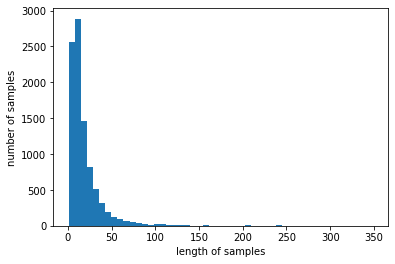

In [44]:
#패딩
print('리뷰의 최대 길이 :',max(len(review) for review in tk))
print('리뷰의 평균 길이 :',sum(map(len, tk))/len(tk))
plt.hist([len(review) for review in tk], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

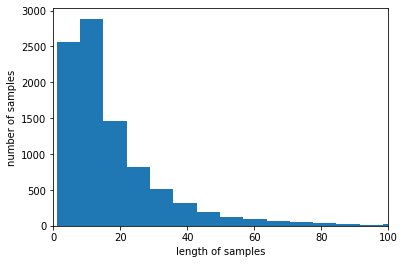

In [45]:
plt.hist([len(review) for review in tk], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.xlim(0, 100)
plt.show()

max_len이 50 정도면 될것 같음

In [46]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 50
below_threshold_len(max_len, tk)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 94.36498548230993


In [47]:
final = pad_sequences(tk, maxlen=max_len)

In [79]:
final_ = list(map(lambda x:[x],final.astype(object)))

In [80]:
final_df = pd.DataFrame(final_,columns=['word'])
y_df = pd.DataFrame(yy)

In [76]:
final_df

,word
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
9294,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9295,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9296,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9297,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


final_df

In [81]:
final_df = pd.concat([final_df, y_df], axis=1)
final_df.columns = ['word','label']

In [83]:
final_df.to_csv('./data/processed/kkma_df.csv')